In [1]:
import configparser
import os
import sys
from pathlib import Path
from functools import reduce
import matplotlib.pyplot as plt
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import explode, split, col, when, expr
from pyspark.sql import functions as F

In [2]:
root_dir = Path.cwd().parent.parent
CONFIG_PATH = str(root_dir / 'config.ini')

if not os.path.exists(CONFIG_PATH):
    raise FileNotFoundError(f"Input file not found: {CONFIG_PATH}")

In [3]:
config = configparser.ConfigParser()
config.optionxform = str
config.read(CONFIG_PATH)
spark_conf = SparkConf().setAll(config['SPARK'].items())
SOURCE_DATA_PATH = str(root_dir / config['DATA']['source'])
PROCESSED_DATA_PATH = str(root_dir / config['DATA']['processed'])
MODEL_PATH = str(root_dir / config['MODEL']['model_path'])
OUTPUT = os.path.join(root_dir, "data", "output")
SAMPLE = os.path.join(root_dir, "data", "input.txt")

In [4]:
spark = SparkSession.builder \
    .appName("BigDataLab5") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


print(spark.version)
lines = spark.read.text(SAMPLE)
words = lines.select(explode(split(col("value"), "\\s+")).alias("word"))
word_counts = words.groupBy("word").count()
word_counts.show(truncate=False)
word_counts.write.mode("overwrite").csv(OUTPUT)
spark.stop()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/16 13:23:12 WARN Utils: Your hostname, MacBook-Air-Ivan-2.local, resolves to a loopback address: 127.0.0.1; using 192.168.31.103 instead (on interface en0)
25/09/16 13:23:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/16 13:23:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


4.0.1
+-----+-----+
|word |count|
+-----+-----+
|you  |1    |
|how  |1    |
|hello|1    |
|Hello|2    |
|spark|1    |
|are  |1    |
|world|1    |
|itmo |1    |
+-----+-----+



In [5]:
print("\n=== Spark Configuration Parameters ===")
for k, v in spark.sparkContext.getConf().getAll():
    print(f"{k}: {v}")
print("=== End Configuration ===\n")


=== Spark Configuration Parameters ===
spark.app.submitTime: 1758018192699
spark.rdd.compress: True
spark.hadoop.fs.s3a.vectored.read.min.seek.size: 128K
spark.sql.warehouse.dir: file:/Users/ivanzolin/Documents/itmo-magistracy/mle-bigdata/labs/bigdata-lab5/src/notebook/spark-warehouse
spark.executor.extraJavaOptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-modules=jdk.incubator.vector --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAME

In [6]:
spark = SparkSession.builder \
    .appName("KMeans") \
    .master("local[*]") \
    .config(conf=spark_conf) \
    .getOrCreate()

In [7]:
df = spark.read.option("header", True) \
               .option("sep", "\t") \
               .option("inferSchema", True) \
               .csv(SOURCE_DATA_PATH)
df.show(5, truncate=False)
df.printSchema()

25/09/16 13:23:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+---------------------------------------------------------------------------------------+--------------------------+----------+-------------------+---------------+----------------------+----------------+--------------+---------------------+------------------------------+------------------------+------------+---------+---------+--------------+------------+--------------+---------------------------+--------------------------------+--------------------------+----------------------------------------------------------------+---------------------------------------------------------------------+------------------------------------------------------------+---------------------------+------------------------------------+------------------------------+--------------------+-------------------------+---------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------

In [8]:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

Number of rows: 4051190
Number of columns: 214


In [9]:
for idx, col_name in enumerate(df.columns):
    print(f"{idx}: {col_name}")

0: code
1: url
2: creator
3: created_t
4: created_datetime
5: last_modified_t
6: last_modified_datetime
7: last_modified_by
8: last_updated_t
9: last_updated_datetime
10: product_name
11: abbreviated_product_name
12: generic_name
13: quantity
14: packaging
15: packaging_tags
16: packaging_en
17: packaging_text
18: brands
19: brands_tags
20: brands_en
21: categories
22: categories_tags
23: categories_en
24: origins
25: origins_tags
26: origins_en
27: manufacturing_places
28: manufacturing_places_tags
29: labels
30: labels_tags
31: labels_en
32: emb_codes
33: emb_codes_tags
34: first_packaging_code_geo
35: cities
36: cities_tags
37: purchase_places
38: stores
39: countries
40: countries_tags
41: countries_en
42: ingredients_text
43: ingredients_tags
44: ingredients_analysis_tags
45: allergens
46: allergens_en
47: traces
48: traces_tags
49: traces_en
50: serving_size
51: serving_quantity
52: no_nutrition_data
53: additives_n
54: additives
55: additives_tags
56: additives_en
57: nutriscore

In [10]:
nutrient_columns = df.columns[88:]
df_nutrients = df.select(nutrient_columns)

print(f"Columns left: {len(nutrient_columns)}")
df_nutrients.printSchema()

Columns left: 126
root
 |-- energy-kj_100g: double (nullable = true)
 |-- energy-kcal_100g: double (nullable = true)
 |-- energy_100g: double (nullable = true)
 |-- energy-from-fat_100g: double (nullable = true)
 |-- fat_100g: double (nullable = true)
 |-- saturated-fat_100g: double (nullable = true)
 |-- butyric-acid_100g: double (nullable = true)
 |-- caproic-acid_100g: double (nullable = true)
 |-- caprylic-acid_100g: double (nullable = true)
 |-- capric-acid_100g: double (nullable = true)
 |-- lauric-acid_100g: double (nullable = true)
 |-- myristic-acid_100g: double (nullable = true)
 |-- palmitic-acid_100g: double (nullable = true)
 |-- stearic-acid_100g: double (nullable = true)
 |-- arachidic-acid_100g: double (nullable = true)
 |-- behenic-acid_100g: double (nullable = true)
 |-- lignoceric-acid_100g: double (nullable = true)
 |-- cerotic-acid_100g: double (nullable = true)
 |-- montanic-acid_100g: double (nullable = true)
 |-- melissic-acid_100g: double (nullable = true)
 |--

In [11]:
df_cleaned = df_nutrients.filter(
    ~reduce(lambda a, b: a & b, [col(c).isNull() for c in df_nutrients.columns])
)
remaining_count = df_cleaned.count()
print(f"Remaining number of rows after filtering: {remaining_count}")

25/09/16 13:24:28 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


Remaining number of rows after filtering: 3163955


In [12]:
df_filled = df_cleaned.fillna(0.0)
df_filled.describe().show(truncate=False)

25/09/16 13:24:58 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1603.8 KiB


+-------+-----------------+----------------------+---------------------+--------------------+------------------+------------------+-----------------+---------------------+---------------------+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+---------------------+---------------------+---------------------+--------------------+--------------------+------------------------+---------------------+------------------------+--------------------+--------------------+-------------------------+--------------------------+-------------------------+---------------------+---------------------+-------------------------+--------------------------------+--------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+-------------------+---------------------+---

In [13]:
# Bounds for cleansing
lower_bound = 0.0
upper_bound = 1000.0

batch_size = 50
medians = {}

# Compute medians for all numeric columns at once
numeric_cols = [c for c, t in df_filled.dtypes if t in ('int', 'double', 'float', 'long')]


# Process 20–50 columns at a time
for i in range(0, len(numeric_cols), batch_size):
    batch = numeric_cols[i:i+batch_size]
    batch_exprs = [F.expr(f"percentile_approx(`{c}`, 0.5)").alias(c) for c in batch]
    batch_medians = df_filled.agg(*batch_exprs).collect()[0].asDict()
    medians.update(batch_medians)

# Build all column transformations in a single select to avoid repeated withColumn
df_cleansed = df_filled.select([
    when((col(c) < lower_bound) | (col(c) > upper_bound), medians[c]).otherwise(col(c)).alias(c)
    if c in medians else col(c)
    for c in df_filled.columns
])

df_cleansed.describe().show(truncate=False)


25/09/16 13:26:41 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:27:37 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:28:31 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:29:05 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:29:44 WARN DAGScheduler: Broadcasting large task binary with size 1713.1 KiB


+-------+------------------+------------------+-----------------+--------------------+------------------+------------------+--------------------+---------------------+---------------------+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+---------------------+---------------------+---------------------+--------------------+--------------------+------------------------+---------------------+------------------------+--------------------+--------------------+-------------------------+--------------------------+-------------------------+--------------------+---------------------+-------------------------+--------------------------------+--------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+---------------------+---------

In [18]:
df_cleansed = df_cleansed.fillna(0, subset=nutrient_columns)
for c in nutrient_columns:
    df_cleansed = df_cleansed.withColumn(c, col(c).cast("double"))

In [19]:
assembler = VectorAssembler(
    inputCols=nutrient_columns,
    outputCol="features",
    handleInvalid="skip"  
)
assembled_df = assembler.transform(df_cleansed)

In [20]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

25/09/16 13:34:34 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


In [21]:
errors = []
k_values = list(range(2, 15)) 

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaled_features")
    model = kmeans.fit(scaled_df)
    wssse = model.summary.trainingCost
    errors.append(wssse)
    print(f"k = {k}, WSSSE = {wssse}")

25/09/16 13:36:34 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:36:35 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:37:10 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:38:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/09/16 13:38:59 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 2, WSSSE = 381112908.42536825


25/09/16 13:39:44 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:40:16 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:42:04 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 3, WSSSE = 373196357.18142015


25/09/16 13:42:55 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:43:29 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:45:32 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 4, WSSSE = 375233866.33864015


25/09/16 13:46:28 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:47:03 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:49:13 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 5, WSSSE = 368004760.8987289


25/09/16 13:50:19 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:51:42 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:54:08 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 6, WSSSE = 367302385.07527846


25/09/16 13:54:51 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:55:24 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 13:57:36 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 7, WSSSE = 351904714.0469367


25/09/16 13:58:42 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:00:09 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:02:35 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 8, WSSSE = 348018965.4198176


25/09/16 14:03:45 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:05:05 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:07:42 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 9, WSSSE = 345642070.6479189


25/09/16 14:08:57 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:10:08 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:12:35 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 10, WSSSE = 350760652.6371238


25/09/16 14:13:21 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:13:55 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:16:14 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 11, WSSSE = 341708548.18484837


25/09/16 14:16:50 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:17:26 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:19:48 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 12, WSSSE = 340901530.16569847


25/09/16 14:21:02 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:22:23 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:24:59 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 13, WSSSE = 333131871.68694407


25/09/16 14:25:45 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:26:22 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:29:54 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.


k = 14, WSSSE = 333438180.69092953


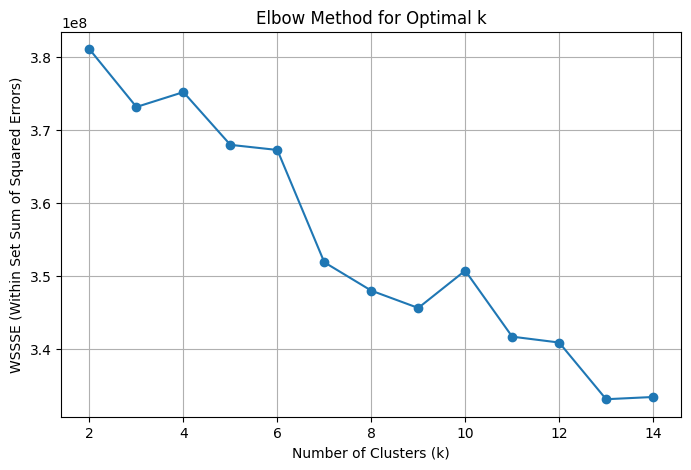

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE (Within Set Sum of Squared Errors)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

25/09/16 14:45:11 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:45:48 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:47:31 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:48:12 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:48:50 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 2, silhouette = 0.9999


25/09/16 14:49:40 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:50:42 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:52:30 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:53:13 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:53:46 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 3, silhouette = 0.9999


25/09/16 14:54:16 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:54:48 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:56:39 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:57:26 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:57:59 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 4, silhouette = 0.9995


25/09/16 14:58:30 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 14:59:02 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:01:14 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:02:07 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:02:42 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 5, silhouette = 0.9995


25/09/16 15:03:20 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:04:28 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:06:47 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:07:58 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:09:01 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 6, silhouette = 0.9994


25/09/16 15:10:01 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:11:02 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:13:05 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:13:47 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:14:18 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 7, silhouette = 0.0556


25/09/16 15:14:50 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:15:24 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:17:17 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:18:01 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:18:29 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 8, silhouette = 0.0513


25/09/16 15:19:00 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:19:32 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:21:45 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:22:31 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:23:02 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 9, silhouette = 0.0555


25/09/16 15:23:34 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:24:09 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:25:52 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:26:32 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:27:05 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 10, silhouette = 0.6634


25/09/16 15:27:39 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:28:14 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:29:59 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:30:48 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:31:20 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 11, silhouette = 0.0921


25/09/16 15:31:50 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:32:23 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:34:28 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:35:36 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:36:35 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 12, silhouette = 0.0487


25/09/16 15:37:34 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:38:35 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:40:43 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:41:26 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:41:57 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 13, silhouette = 0.0841


25/09/16 15:42:27 WARN BaseSessionStateBuilder$$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:43:00 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:45:10 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:45:57 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.optimizer.maxIterations' to a larger value.
25/09/16 15:46:30 WARN BaseSessionStateBuilder$anon$2: Max iterations (100) reached for batch Operator Optimization before Inferring Filters, please set 'spark.sql.opt

k = 14, silhouette = -0.0781


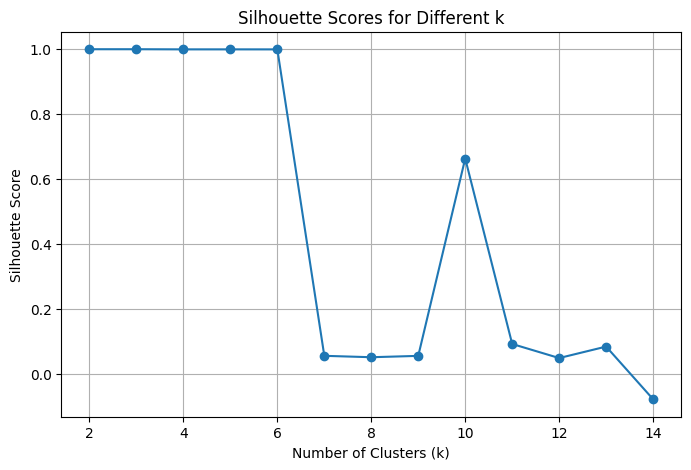

In [23]:
silhouette_scores = []
k_values = list(range(2, 15))

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol="scaled_features", predictionCol="cluster")
    model = kmeans.fit(scaled_df)
    predictions = model.transform(scaled_df)

    evaluator = ClusteringEvaluator(
        featuresCol="scaled_features",
        predictionCol="cluster",
        metricName="silhouette",
        distanceMeasure="squaredEuclidean"
    )
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)
    print(f"k = {k}, silhouette = {score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.grid(True)
plt.show()
spark.stop()